In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# Tentukan path untuk data
train_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Train & Validation"
test_data_dir = "/Users/anggun/Downloads/SKRIPSI ANGGUN/ANGGUN/2. Data Test"

In [3]:
# Fungsi untuk memuat data dari folder dan mengembalikan generator
batch_size = 32
target_size = (299, 299)  # Ganti target_size ke 299x299
def load_data(data_dir, batch_size, target_size):
    data_generator = ImageDataGenerator(rescale=1./255)
    data_flow = data_generator.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    return data_flow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Fungsi augmentasi khusus
def custom_augmentation(x):
    if np.random.random() < 0.5:
        x = np.flip(x, axis=1)  # Flip horizontal
    if np.random.random() < 0.5:
        x = np.flip(x, axis=0)  # Flip vertikal
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, 90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate right (90 derajat)
    if np.random.random() < 0.5:
        x = tf.keras.preprocessing.image.random_rotation(x, -90, row_axis=0, col_axis=1, channel_axis=2)  # Rotate left (-90 derajat)
    return x

# Data generator dengan augmentasi
data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_augmentation
)

# Aliran data
data_flow = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(299, 299),  # Ubah ke 299x299
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 540 images belonging to 3 classes.


In [5]:
# Memuat data train ke dalam array
X_data = []
y_data = []

In [6]:
# Loop through batches using the iterator protocol (no need for next())
for i, (X_batch, y_batch) in enumerate(data_flow):
    X_data.append(X_batch)
    y_data.append(y_batch)
    
    # Exit the loop once we've got all the batches (although this is redundant because ⁠ data_flow ⁠ handles it)
    if i >= len(data_flow) - 1:
        break
# Memuat data test
test_datagen = ImageDataGenerator(rescale=1./255)#1./25 untuk supaya sistem bisa mengenali data sekecil mungkin (225 adalh piksel terkecil dari gambar)
test_generator = test_datagen.flow_from_directory(
     test_data_dir,
    target_size=(299, 299),  # Ubah ke 299x299
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 60 images belonging to 3 classes.


In [7]:
X_data = np.concatenate(X_data)
y_data = np.concatenate(y_data)

In [8]:
#  Model VGGNet-16
def create_vgg_model():
    vgg_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    vgg_model.trainable = False  # Menggunakan bobot yang sudah dilatih
    
    modelvgg = tf.keras.Sequential([
        vgg_model,
        tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    # Kompilasi model
    #jika optimizers.Adam yaitu learning_rate nya semakin besar maka proses pembelajarannya semakin cepat dan jika learning_rate nya semakin maka proses pembelajarannya semakin lama/ pelan"  
    modelvgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    
    return modelvgg

In [9]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [10]:
# ====== 2. IMPORT LIBRARY LAIN ======
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

# Misalnya, Anda telah mengumpulkan histori dari setiap fold
fold_accuracies = []
fold_losses = []
fold_val_accuracies = []
fold_val_losses = []
fold_accuracy = []
y_true_val = []
y_pred_val = []
y_true_test = []
y_pred_test = []
confusion_matrices=[]
fold_summaries = []

# epochs=10 itu sama dengan jika kita bnyak belajar dari sumber" maka ilmu akan bertambah dan begitu juga dengan pembelajaran pada gambar ini semakin banyak mempelajari gambar maka akan semakin baik modelnya
for fold, (train_index, val_index) in enumerate (kfold.split(X_data)):
    X_train, X_val = X_data[train_index], X_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]
    
    modelvgg = create_vgg_model()
    history = modelvgg.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_val, y_val)
    )
    #evaluasi
    _, accuracy = modelvgg.evaluate(X_val, y_val)
    fold_accuracy.append(accuracy)
    
    # Simpan histori dari setiap fold
    fold_accuracies.append(history.history['accuracy'])
    fold_losses.append(history.history['loss'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    fold_val_losses.append(history.history['val_loss'])
    
    # Prediksi untuk data validasi
    y_pred_fold = np.argmax(modelvgg.predict(X_val), axis=1)
    y_true_fold = np.argmax(y_val, axis=1)

    y_pred_val.extend(y_pred_fold)
    y_true_val.extend(y_true_fold)
# Menghitung confusion matrix
    cm = confusion_matrix(y_true_fold, y_pred_fold)
    confusion_matrices.append(cm)
    
    # Menghitung summary dari confusion matrix
    accuracy = accuracy_score(y_true_fold, y_pred_fold)
    precision = precision_score(y_true_fold, y_pred_fold, average='weighted')
    recall = recall_score(y_true_fold, y_pred_fold, average='weighted')
    f1 = f1_score(y_true_fold, y_pred_fold, average='weighted')
    fold_summaries.append((accuracy, precision, recall, f1))

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - accuracy: 0.4123 - loss: 1.1924 - val_accuracy: 0.8444 - val_loss: 0.6405
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 117s 9s/step - accuracy: 0.8506 - loss: 0.4659 - val_accuracy: 0.8148 - val_loss: 0.4838
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step - accuracy: 0.8774 - loss: 0.2907 - val_accuracy: 0.8593 - val_loss: 0.3745
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step - accuracy: 0.9235 - loss: 0.2392 - val_accuracy: 0.9259 - val_loss: 0.2478
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step - accuracy: 0.9398 - loss: 0.1929 - val_accuracy: 0.9037 - val_loss: 0.2706
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 120s 9s/step - accuracy: 0.9327 - loss: 0.1531 - val_accuracy: 0.9111 - val_loss: 0.2569
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step - accuracy: 0.9337 - loss: 0.1391 - val_accuracy: 0.9259 - val_loss: 0.2444
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 119s 9s/step - accuracy: 0.9577 - loss: 0.1001 - val_accuracy: 0.8889 - v

In [11]:
# Contoh output
print("Akurasi setiap fold:", fold_accuracy)
print("Prediksi validasi:", y_pred_val)
print("Label asli validasi:", y_true_val)
print("Prediksi test:", y_pred_test)
print("Label asli test:", y_true_test)

Akurasi setiap fold: [0.9259259104728699, 0.9111111164093018, 0.9481481313705444, 0.8962963223457336]
Prediksi validasi: [np.int64(0), np.int64(0), np.int64(0), np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(0), np.int64(2), np.int64(2), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(1), np.int64(1), np.int64(2), np.int64(1), np.int64(2), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(2), np.int64(0), np.int64(1), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int64(2), np.int64(0), np.int64(2), np.int64(1), np.int64(2), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(2), np.int64(2), np.int64(1), np.int64(0), np.int64(1), np.int64(2), np.int64(2), np.int6

In [12]:
modelvgg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 9, 9, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 9, 32)       │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,355,307 (58.58 MB)

 Trainable params: 213,539 (834.14 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 427,080 (1.63 MB)

In [13]:
# Plotting grafik untuk semua fold
#epochs = range(1, 11) jika  epoch sebanyak 11
epochs = list(range(1, 11))  # 1 sampai 20

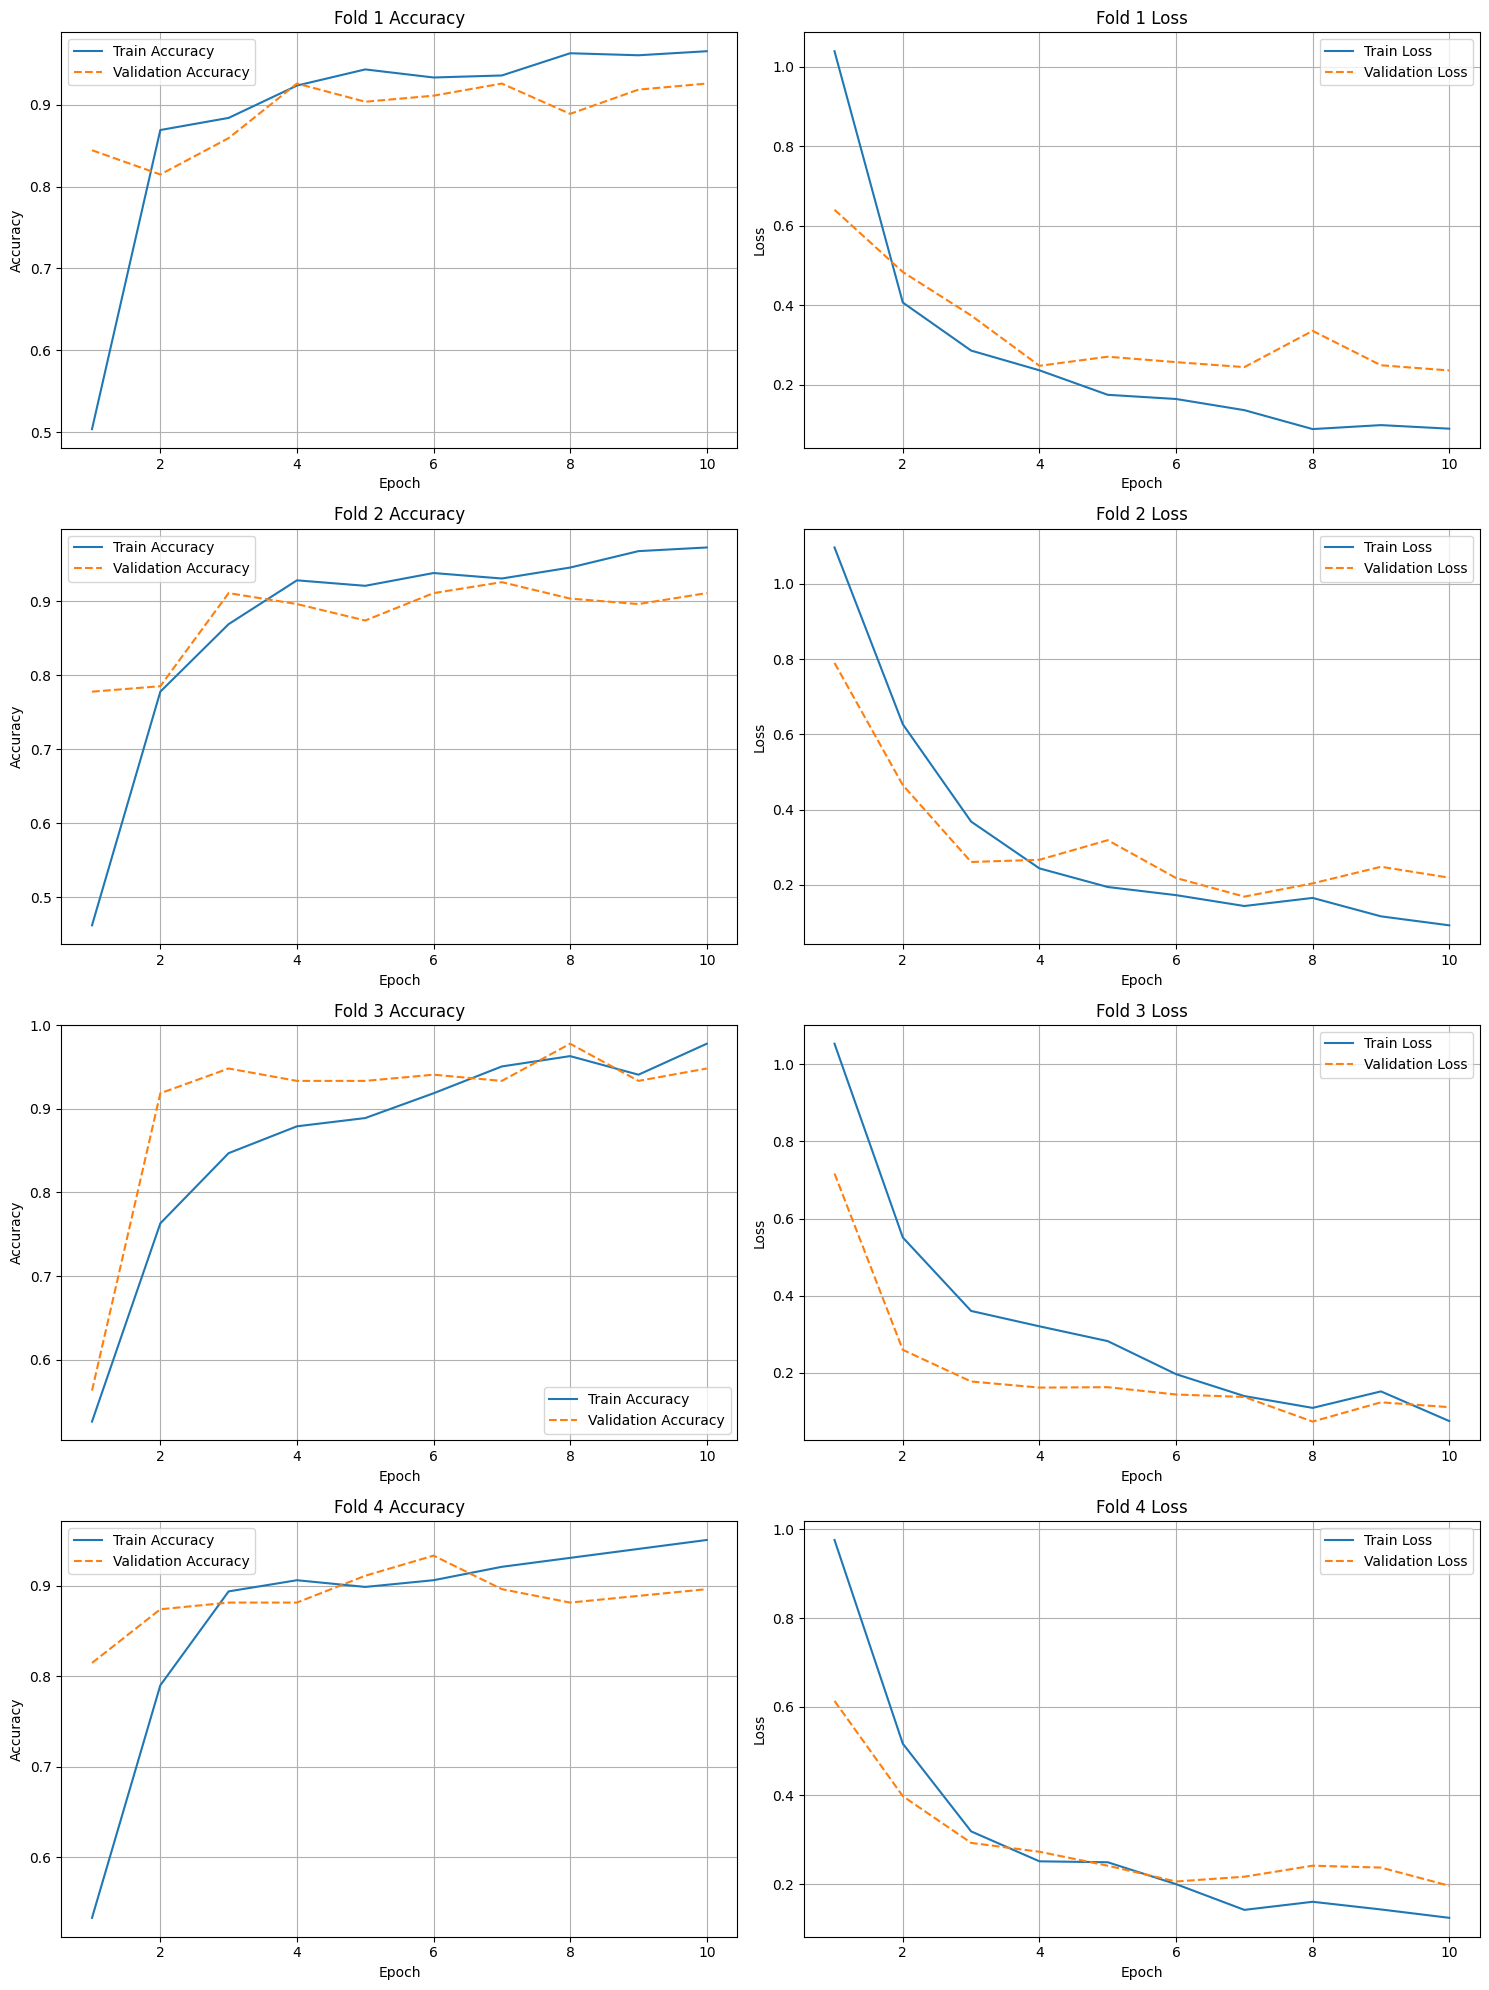

In [14]:
import matplotlib.pyplot as plt

# Pastikan fold_accuracies, fold_val_accuracies, fold_losses, fold_val_losses, dan epochs terdefinisi dengan benar

# Tentukan jumlah fold
num_folds = len(fold_accuracies)

# Setup subplot grid dengan 4 baris dan 2 kolom (total 8 grafik)
plt.figure(figsize=(15, 20))

for i in range(num_folds):
    # Subplot untuk Accuracy
    plt.subplot(num_folds, 2, 2 * i + 1)
    plt.plot(epochs, fold_accuracies[i], label='Train Accuracy')
    plt.plot(epochs, fold_val_accuracies[i], label='Validation Accuracy', linestyle='--')
    plt.title(f'Fold {i + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Subplot untuk Loss
    plt.subplot(num_folds, 2, 2 * i + 2)
    plt.plot(epochs, fold_losses[i], label='Train Loss')
    plt.plot(epochs, fold_val_losses[i], label='Validation Loss', linestyle='--')
    plt.title(f'Fold {i + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

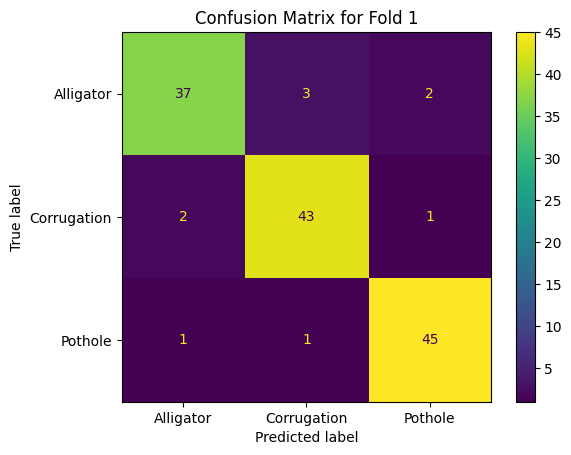

Summary for Fold 1:
Accuracy: 0.9259259259259259
Precision: 0.925908195429472
Recall: 0.9259259259259259
F1 Score: 0.9256769572034524




<Figure size 640x480 with 0 Axes>

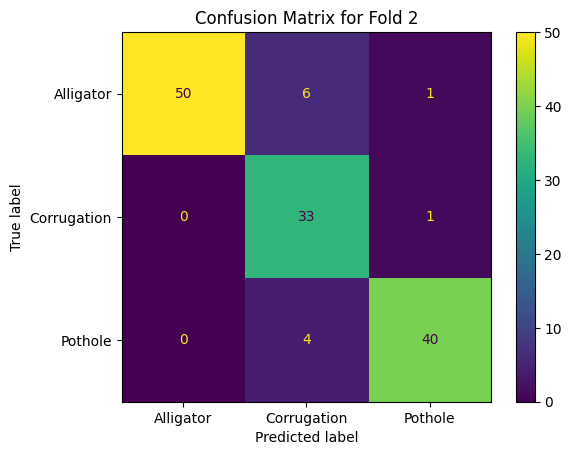

Summary for Fold 2:
Accuracy: 0.9111111111111111
Precision: 0.9259095197079693
Recall: 0.9111111111111111
F1 Score: 0.9136601313954062




<Figure size 640x480 with 0 Axes>

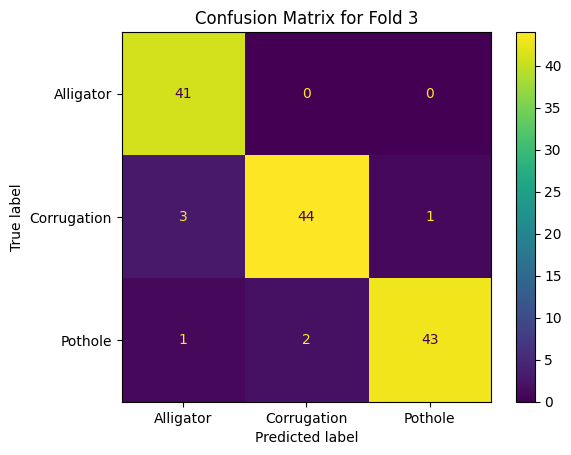

Summary for Fold 3:
Accuracy: 0.9481481481481482
Precision: 0.9498010702841619
Recall: 0.9481481481481482
F1 Score: 0.9480351779565589




<Figure size 640x480 with 0 Axes>

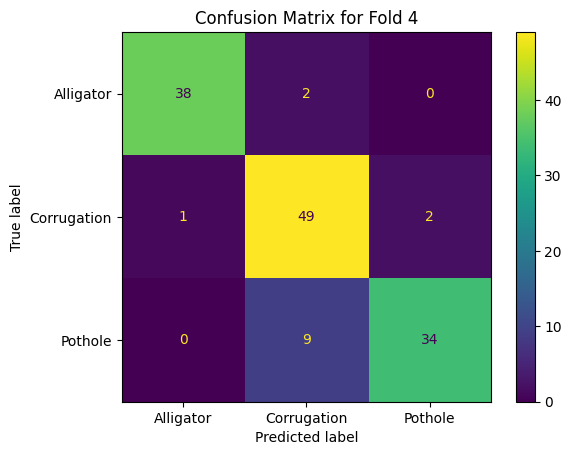

Summary for Fold 4:
Accuracy: 0.8962962962962963
Precision: 0.9040899018676797
Recall: 0.8962962962962963
F1 Score: 0.896249413970933




In [15]:
# Menampilkan confusion matrices dan summaries setelah loop selesai
for i, cm in enumerate(confusion_matrices):
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_flow.class_indices.keys())
    disp.plot()
    plt.title(f'Confusion Matrix for Fold {i + 1}')
    plt.show()
    
    accuracy, precision, recall, f1 = fold_summaries[i]
    print(f"Summary for Fold {i + 1}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("\n")

In [16]:
# Menampilkan rata-rata akurasi dari cross-validation
print("Cross-validation accuracy:", np.mean(fold_accuracy))

Cross-validation accuracy: 0.9203703701496124


In [17]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true_fold, y_pred_fold)
confusion_matrices.append(cm)

In [18]:
# Menampilkan confusion matrices
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n{cm}\n")

Confusion Matrix for Fold 1:
[[37  3  2]
 [ 2 43  1]
 [ 1  1 45]]

Confusion Matrix for Fold 2:
[[50  6  1]
 [ 0 33  1]
 [ 0  4 40]]

Confusion Matrix for Fold 3:
[[41  0  0]
 [ 3 44  1]
 [ 1  2 43]]

Confusion Matrix for Fold 4:
[[38  2  0]
 [ 1 49  2]
 [ 0  9 34]]

Confusion Matrix for Fold 5:
[[38  2  0]
 [ 1 49  2]
 [ 0  9 34]]



/opt/anaconda3/envs/Anggun/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 473ms/step - accuracy: 0.9770 - loss: 0.0591
Test Accuracy: 0.9166666865348816
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 487ms/step


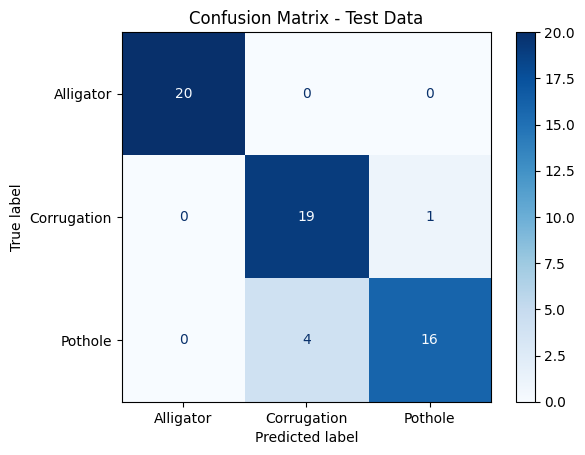

              precision    recall  f1-score   support

   Alligator       1.00      1.00      1.00        20
 Corrugation       0.83      0.95      0.88        20
     Pothole       0.94      0.80      0.86        20

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [19]:
test_scores = modelvgg.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])
# Prediksi dari model
y_pred_test = modelvgg.predict(test_generator)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Label sebenarnya
y_true_test = test_generator.classes

# Hitung confusion matrix
test_cm = confusion_matrix(y_true_test, y_pred_test_classes)

# Nama kelas
classes = list(test_generator.class_indices.keys())

# Tampilkan confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=classes)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Tampilkan laporan klasifikasi
print(classification_report(y_true_test, y_pred_test_classes, target_names=classes))

In [23]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true_fold, y_pred_fold)
confusion_matrices.append(cm)

In [30]:
# Menampilkan precision, recall, f1-score, dan accuracy dari hasil confusion matrix untuk data train
print(classification_report(y_true_val, y_pred_val, target_names=classes))

              precision    recall  f1-score   support

   Alligator       0.95      0.92      0.94       180
 Corrugation       0.86      0.94      0.90       180
     Pothole       0.95      0.90      0.93       180

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540



In [31]:
test_scores = modelvgg.evaluate(test_generator)
print("Test Accuracy:", test_scores[1])

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 533ms/step - accuracy: 0.9770 - loss: 0.0591
Test Accuracy: 0.9166666865348816


In [34]:
modelvgg.save('vggnet16_new2.h5')